In [1]:
# this is copy from 0827. just to remove _ inside one hot encoding.
import numpy as np
import Bio
from pathlib import Path
import gemmi
from tqdm.notebook import tqdm
import concurrent.futures
import pickle as pkl
import matplotlib.pyplot as plt
import random
import itertools
from tqdm.contrib.concurrent import process_map, thread_map
#from pyrosetta import create_score_function, pose_from_pdb
#import rosetta_min.run as run
#import h5py
#import datasets
import torch
import urllib

import numpy as np
import pandas as pd
import Bio.PDB
from pathlib import Path
import gemmi
from tqdm.notebook import tqdm, trange
import concurrent.futures
import pickle as pkl
import matplotlib.pyplot as plt
import random
import itertools
from tqdm.contrib.concurrent import process_map, thread_map
import torch
import urllib


one_letter_aa_mapping = {'VAL':'V', 'ILE':'I', 'LEU':'L', 'GLU':'E', 'GLN':'Q', \
'ASP':'D', 'ASN':'N', 'HIS':'H', 'TRP':'W', 'PHE':'F', 'TYR':'Y',    \
'ARG':'R', 'LYS':'K', 'SER':'S', 'THR':'T', 'MET':'M', 'ALA':'A',    \
'GLY':'G', 'PRO':'P', 'CYS':'C'}

##### Functions below adapted from trRosetta https://github.com/RosettaCommons/trRosetta2/blob/main/trRosetta/coords6d.py

# calculate dihedral angles defined by 4 sets of points
def get_dihedrals(a, b, c, d):
    
    # Ignore divide by zero errors
    np.seterr(divide='ignore', invalid='ignore')
    
    b0 = -1.0*(b - a)
    b1 = c - b
    b2 = d - c
    
    b1 /= np.linalg.norm(b1, axis=-1)[:,None]
    v = b0 - np.sum(b0*b1, axis=-1)[:,None]*b1
    w = b2 - np.sum(b2*b1, axis=-1)[:,None]*b1

    x = np.sum(v*w, axis=-1)
    y = np.sum(np.cross(b1, v)*w, axis=-1)

    return np.arctan2(y, x)

# calculate planar angles defined by 3 sets of points
def get_angles(a, b, c):

    v = a - b
    v /= np.linalg.norm(v, axis=-1)[:,None]

    w = c - b
    w /= np.linalg.norm(w, axis=-1)[:,None]

    x = np.sum(v*w, axis=1)

    return np.arccos(x)
#/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023
# get 6d coordinates from x,y,z coords of N,Ca,C atoms
def get_coords6d(xyz, dmax=20.0, normalize=True):

    nres = xyz.shape[1]

    # three anchor atoms
    N  = xyz[0]
    Ca = xyz[1]
    C  = xyz[2]

    # recreate Cb given N,Ca,C
    b = Ca - N
    c = C - Ca
    a = np.cross(b, c)
    Cb = -0.58273431*a + 0.56802827*b - 0.54067466*c + Ca

    # fast neighbors search to collect all
    # Cb-Cb pairs within dmax
    kdCb = scipy.spatial.cKDTree(Cb)
    indices = kdCb.query_ball_tree(kdCb, dmax)

    # indices of contacting residues
    idx = np.array([[i,j] for i in range(len(indices)) for j in indices[i] if i != j]).T
    idx0 = idx[0]
    idx1 = idx[1]

    # Cb-Cb distance matrix
    dist6d = np.full((nres, nres),dmax)
    dist6d[idx0,idx1] = np.linalg.norm(Cb[idx1]-Cb[idx0], axis=-1)

    # matrix of Ca-Cb-Cb-Ca dihedrals
    omega6d = np.zeros((nres, nres))
    omega6d[idx0,idx1] = get_dihedrals(Ca[idx0], Cb[idx0], Cb[idx1], Ca[idx1])

    # matrix of polar coord theta
    theta6d = np.zeros((nres, nres))
    theta6d[idx0,idx1] = get_dihedrals(N[idx0], Ca[idx0], Cb[idx0], Cb[idx1])

    # matrix of polar coord phi
    phi6d = np.zeros((nres, nres))
    phi6d[idx0,idx1] = get_angles(Ca[idx0], Cb[idx0], Cb[idx1])
    
    # Normalize all features to [-1,1]
    if normalize:
        # [4A, 20A]
        dist6d = dist6d/dmax*2 - 1
        # [-pi, pi]
        omega6d = omega6d/math.pi
        # [-pi, pi]
        theta6d = theta6d/math.pi
        # [0, pi]
        phi6d = phi6d/math.pi*2 - 1

    return dist6d, omega6d, theta6d, phi6d

##### Process 6D features

def get_dummy_scaler():
    return lambda x:x

def one_hot_encode(seq):
    alphabet = "ARNDCEQGHILKMFPSTWYV"
    mapping = dict(zip(alphabet,range(len(alphabet))))
    seq_idx = [mapping[s] for s in seq]
    return np.eye(len(alphabet))[seq_idx]

def one_hot_decode(seq):
    alphabet = "ARNDCEQGHILKMFPSTWYV"
    mapping = dict(zip(range(len(alphabet)),alphabet))
    seq_idx = [np.argmax(i) for i in seq]
    return ''.join([mapping[i] for i in seq_idx])

def process_6d_coords(seq,crd,size=128):

    seq, crd = pad_seq_and_crd(seq,crd,size)
    n = crd[:,0]
    ca = crd[:,1]
    c = crd[:,2]
    bb = np.array([n,ca,c])
    crd_6d = torch.tensor(np.array(get_coords6d(bb)))
    
    # Find first and last non-padding residue
    s_stripped = seq.strip("_")
    s_start_aa = s_stripped[0]
    s_end_aa = s_stripped[-1]

    # Find indices of start/end residues
    start_idx = seq.find(s_start_aa)
    end_idx = size-seq[::-1].find(s_end_aa)

    # Set non-padding residues to 0
    ch = torch.ones((size,size))
    ch[start_idx:end_idx,start_idx:end_idx] = 0
    ch = ch.unsqueeze(0)
    crd_6d = torch.cat([crd_6d,ch],dim=0)
    
    for i in range(4):
        # Boolean matrix of padding residues
        padding = crd_6d[4]==1
        # Distance matrix
        if i == 0:
            crd_6d[i][padding] = 1
        # Phi matrix
        elif i == 3:
            crd_6d[i][padding] = -1
        # Omega, Theta matrix
        else:
            crd_6d[i][padding] = 0
    
    return crd_6d

def get_6d_from_pdb(path,chain="A",normalize=True):
    st = gemmi.read_structure(str(path))
    
    # Extract regions defined in - domains
    # get_polymer extracts just the amino acids (excluding H2O, etc.)
    polymer = st[0][chain].get_polymer()
    length = len(list(polymer))

    tmp_res_list = []
    for res in list(polymer):
        res_info = {"name":res.name,"crds":{}}
        res_info["crds"]["CA"] = res.find_atom("CA","*").pos.tolist()
        res_info["crds"]["N"] = res.find_atom("N","*").pos.tolist()
        res_info["crds"]["C"] = res.find_atom("C","*").pos.tolist()
        assert len(res_info["crds"]["C"]) == len(res_info["crds"]["N"]) == len(res_info["crds"]["CA"]) == 3
        tmp_res_list.append(res_info)

    # Concat coordinates
    n = np.array([res["crds"]["N"] for res in tmp_res_list])
    c = np.array([res["crds"]["C"] for res in tmp_res_list])
    ca = np.array([res["crds"]["CA"] for res in tmp_res_list])
    assert n.shape == c.shape == ca.shape

    bb = np.array([n,ca,c])
    return torch.tensor(np.array(get_coords6d(bb,normalize=normalize)))
        
def extract_6d_coords(path,size=128):
    # Read structure file
    #mmcif_path = path.joinpath(f"{pdb.lower()}.cif")
    mmcif_path = path
    if mmcif_path.is_file():
        st = gemmi.read_structure(str(mmcif_path))
    else:
        #print("1")
        return

    # Extract regions defined in - domains
    # get_polymer extracts just the amino acids (excluding H2O, etc.)
    st = gemmi.read_structure(str(path))
    st.setup_entities()
    polymer = st[0][chain].get_polymer()
    length = len(list(polymer))
    #print(list(polymer))

    if length < 40 or length > size:
       # print("2")
        return 
    
    # Parse through each residue and obtain coordinates
    # Try-except catches errors when Ca/N/C coordinates are not present in the PDB file
    try:
        # # Read structure file
        # mmcif_path = path.joinpath(f"{pdb.lower()}.cif")
        # pdb_path = path.joinpath(f"pdb{pdb.lower()}.ent")
        # if mmcif_path.is_file():
        #     st = gemmi.read_structure(str(mmcif_path))
        # elif pdb_path.is_file():
        #     st = gemmi.read_structure(str(pdb_path))
        # else:
        #     return
        
        # Extract regions defined in - domains
        # get_polymer extracts just the amino acids (excluding H2O, etc.)
        st = gemmi.read_structure(str(path))
        st.setup_entities()
        polymer = st[0][0].get_polymer()
        #polymer = st[0][chain].get_polymer()
        length = len(list(polymer))

        if length < 40 or length > size:
            return 
        
        tmp_res_list = []
        for res in list(polymer):
            res_info = {"name":res.name,"crds":{}}
            res_info["crds"]["CA"] = res.find_atom("CA","*").pos.tolist()
            res_info["crds"]["N"] = res.find_atom("N","*").pos.tolist()
            res_info["crds"]["C"] = res.find_atom("C","*").pos.tolist()
            assert len(res_info["crds"]["C"]) == len(res_info["crds"]["N"]) == len(res_info["crds"]["CA"]) == 3
            tmp_res_list.append(res_info)
    except:
        return

    # Get sequence
    seq = [res["name"] for res in tmp_res_list]
    seq = ''.join([one_letter_aa_mapping[aa] for aa in seq])

    # Concat coordinates
    n = np.array([res["crds"]["N"] for res in tmp_res_list])
    c = np.array([res["crds"]["C"] for res in tmp_res_list])
    ca = np.array([res["crds"]["CA"] for res in tmp_res_list])
    if not n.shape == c.shape == ca.shape:
        return
    
    # Generate 6D coordinates
    crds = np.stack([n,ca,c])
    crd_6d = torch.tensor(get_coords6d(crds))
    
    # Pad and add padding channel
    
    #first change: torch.ones to torch.zeros
    #crd_6d_padded = torch.ones((5,size,size))
    crd_6d_padded = torch.zeros((5,size,size))
    
    start_idx = (size-length)//2
    end_idx = start_idx + length
    
    crd_6d_padded[:4,start_idx:end_idx,start_idx:end_idx] = crd_6d
    
    #second place to change. change it into midlle part for one hot encoding.
    
    #crd_6d_padded[4,start_idx:end_idx,start_idx:end_idx] = -1
    sequence = gemmi.one_letter_code(polymer)
    
    mid_point = int(128/2)
    crd_6d_padded[4,start_idx:end_idx,mid_point-10:mid_point+10] = torch.from_numpy(one_hot_encode(seq))
    # Change matrix values of padding residues
    for i in range(4):
        # Boolean matrix of padding residues
        padding = crd_6d_padded[4]==1
        # Distance matrix
        if i == 0:
            crd_6d_padded[i][padding] = 1
        # Phi matrix
        elif i == 3:
            crd_6d_padded[i][padding] = -1
        # Omega, Theta matrix
        else:
            crd_6d_padded[i][padding] = 0
    
    # Remove NaNs
    if torch.any(torch.isnan(crd_6d_padded)):
        return

    return crd_6d_padded


In [2]:
import scipy.spatial

import concurrent.futures
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import itertools
import scipy
import math
import torch
import gemmi
from torch.utils.data import Dataset, DataLoader, RandomSampler, random_split
from pathlib import Path

path= Path("/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/")

In [3]:
dataset3_l = []

# this is to do a test for fisrt 300.
c = 0
for p in tqdm(path.iterdir()):
    print(p)
    name = p.stem
    chain = name.split("_")[1]
    st = gemmi.read_structure(str(p))
    st.setup_entities()
    try:  
        polymer = st[0][0].get_polymer()
        #print(polymer)
    except:
        print(f"{p.name} skipped - chain file corrupted")
        continue
    if len(polymer) > 128:
        continue
    
    sequence = gemmi.one_letter_code(polymer)
    if "X" in sequence:
        continue
    try:
        #chain = "A"
        encoded_5 = extract_6d_coords(p)
    except:
        #chain = "H"
        encoded_5 = extract_6d_coords(p)        
    backbone_crds = []
    all_atoms_crds = []
    missing=[]
    for idx,res in enumerate(polymer):
        all_atoms = {}
        for atom in res:
            if atom.name == "N":
                n_crd = atom.pos.tolist()
            elif atom.name == "CA":
                ca_crd = atom.pos.tolist()
            elif atom.name == "C":
                c_crd = atom.pos.tolist()
            elif atom.name == "O":
                o_crd = atom.pos.tolist()

            # For chi angle calculations
            all_atoms[atom.name] = atom.pos.tolist()
        
        # Check if backbone atoms are missing
        if all([i in all_atoms for i in ["N","CA","C","O"]]):
            backbone_crds.append([n_crd,ca_crd,c_crd,o_crd])
        else:
            missing.append(idx)

        # All atoms
        all_atoms_crds.append(all_atoms)
    if encoded_5!=None:
        dataset3_l.append({
            "name":str(p).split("/")[-1],
            "seq":gemmi.one_letter_code(polymer),
            "bb_coords":backbone_crds,
            "all_coords": all_atoms_crds,
            "missing": missing,
            "data":encoded_5,
        })
    c+=1
    if c > 300:
        break

    

0it [00:00, ?it/s]

/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/5xj3_D_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/4olx_L_1_110_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/4xnz_F_1_107_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/7qti_H_1_107_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/6did_L_3_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/7ul7_H_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_202

/tmp/ipykernel_8293/592172038.py:282: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  crd_6d = torch.tensor(get_coords6d(crds))


/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/4mxw_V_1_110_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/7mem_K_1_107_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/7tee_L_1_107_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/4fqr_e_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/6bit_J_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/6suz_H_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_202

/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/5wko_G_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/7m7w_H_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/7f7h_C_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/6v8z_F_1_107_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/3csy_G_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/6wmw_M_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_202

/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/7sjo_E_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/6o2b_O_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/6pci_I_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/7kdd_E_1_107_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/4lst_H_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/6p65_H_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_202

/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/7s7i_M_1_107_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/2h9g_B_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/6wxl_J_1_107_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/7rq6_J_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/2dd8_L_1_109_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/8df5_H_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_202

/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/6x98_J_1_107_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/6awq_B_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/7e8c_E_1_107_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/6p3s_M_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/1uac_L_1_107_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/6um6_D_1_107_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_202

/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/4lmq_L_1_110_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/7dzy_P_1_107_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/4xvu_K_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/4ydk_L_1_107_VL.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/7cai_G_1_113_VH.pdb
/home/xxie92/Desktop/backup_for_dell_15/pdb_projects/code/jupterNotebooks/data/antibody_antigen_antibody_only_data_Mar04_2023/5t5f_L_1_107_VL.pdb


In [ ]:
import pickle
with open("train_dataset_antibody_antigen_complex_Mar04.pkl","wb") as fout:
    pickle.dump(new_lst,fout)

In [10]:
dataset3_l[0]["data"].shape

torch.Size([5, 128, 128])

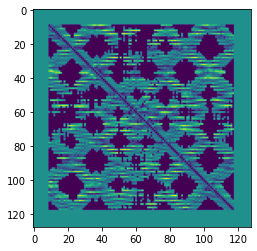

In [58]:
import matplotlib.pyplot as plt
plt.imshow(dataset3_l[120]["data"][3])

In [4]:
# save as pickle file
import pickle
with open("toy_dataset_300_train_dataset_antibody_antigen_complex_Mar04.pkl","wb") as fout:
    pickle.dump(dataset3_l,fout)

In [44]:
len(dataset3_l)

7962

In [50]:
dataset3_l[0]

{'name': '5xj3_D_1_113_VH.pdb',
 'seq': 'QVQLVESGGGVVQPGRSLRLSCAASGFTFSSYTMHWVRQAPGKGLEWVTFISYDGNNKYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAIYYCARTGWLGPFDYWGQGTLVTVS',
 'bb_coords': [[[-9.461, 27.799, -52.134],
   [-10.241, 28.642, -53.031],
   [-9.587, 28.728, -54.404],
   [-10.161, 29.276, -55.345]],
  [[-8.378, 28.187, -54.508],
   [-7.625, 28.226, -55.753],
   [-8.258, 27.331, -56.808],
   [-8.472, 26.141, -56.583]],
  [[-8.553, 27.912, -57.964],
   [-9.203, 27.183, -59.04],
   [-8.446, 27.3, -60.352],
   [-8.127, 28.4, -60.804]],
  [[-8.174, 26.153, -60.961],
   [-7.574, 26.086, -62.287],
   [-8.5, 25.338, -63.243],
   [-8.775, 24.159, -63.015]],
  [[-8.982, 25.996, -64.3],
   [-9.956, 25.359, -65.197],
   [-9.552, 25.465, -66.653],
   [-9.367, 26.555, -67.183]],
  [[-9.424, 24.318, -67.301],
   [-9.061, 24.293, -68.7],
   [-10.294, 24.133, -69.575],
   [-11.355, 23.713, -69.112]],
  [[-10.133, 24.472, -70.848],
   [-11.207, 24.418, -71.832],
   [-10.627, 24.536, -73.235],
   [-9.49, 24.

In [60]:

for i in range(len(dataset3_l)):
    if dataset3_l[i]["data"] == None:
        print(i)

70
72
214
265
339
349
560
594
595
790
1003
1152
1169
1225
1291
1360
1380
1478
1504
1559
1648
1748
1785
1982
2036
2078
2094
2199
2204
2230
2362
2394
2401
2421
2542
2618
2710
2715
2829
2913
2954
3017
3220
3244
3285
3371
3400
3408
3489
3512
3538
3603
3607
3675
3795
3893
3923
3967
3971
4002
4061
4088
4102
4111
4175
4199
4267
4355
4418
4494
4534
4542
4544
4571
4576
4607
4679
4719
4811
4839
4914
4956
4983
4993
5119
5123
5158
5216
5310
5314
5391
5404
5527
5660
5734
5742
5795
5809
5841
5865
6008
6061
6067
6249
6297
6298
6323
6372
6481
6499
6534
6629
6649
6670
6751
6793
6833
6839
6862
7027
7030
7085
7096
7142
7195
7290
7310
7321
7352
7355
7361
7396
7483
7648
7680
7716
7719
7729
7771
7815
7864
7880
7910
7929


In [62]:
new_lst = []
for i in range(len(dataset3_l)):
    if dataset3_l[i]["data"] != None:
        new_lst.append(dataset3_l[i])

In [63]:
len(new_lst)

7818

In [64]:
len(dataset3_l)

7962

In [ ]:
dataset3_l